In [1]:
import cv2
import numpy as np
import glob
import random
import ipyplot
from matplotlib import pyplot as plt

In [2]:
base_path = "images_folder_path"
files_list = []
for i in range(4):
    files_list.append(glob.glob(base_path + str(i) + "/*.jpg"))
    #print(glob.glob(base_path + str(i) + "/*.jpg"))

In [3]:
random.seed(42)
indexes = random.sample(range(0, 9), 7)
print(indexes)

[1, 0, 5, 2, 8, 4, 7]


In [4]:
train_files = []
test_files = []
for L in files_list:
    t = []
    for i in indexes:
        t.append(L[i])
    train_files.append(t)
    test_files.append([x for x in L if x not in t])

#print(train_files)
#print(test_files)


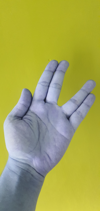
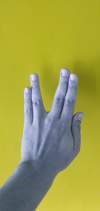
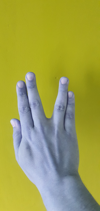
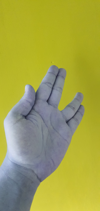
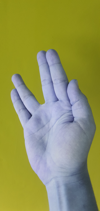
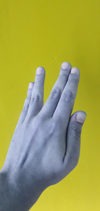
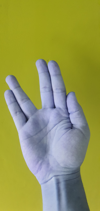


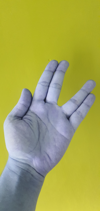
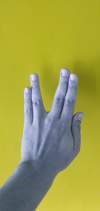
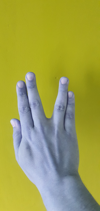
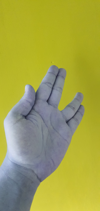
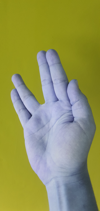
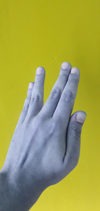
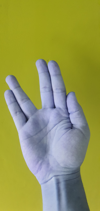


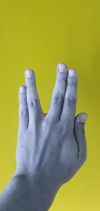
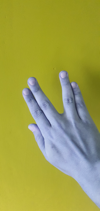
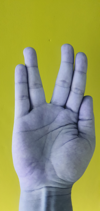


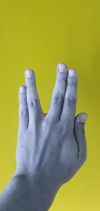
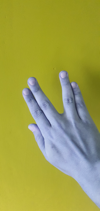
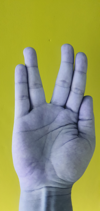

In [5]:
train_images = []
for L in train_files:
    s = []
    for l in L:
        s.append(cv2.imread(l))
    train_images.append(s)

test_images = []
for L in test_files:
    s = []
    for l in L:
        s.append(cv2.imread(l))
    test_images.append(s)

ipyplot.plot_images(train_images[1], max_images = 27, img_width = 100)
ipyplot.plot_images(test_images[1], max_images = 27, img_width = 100)

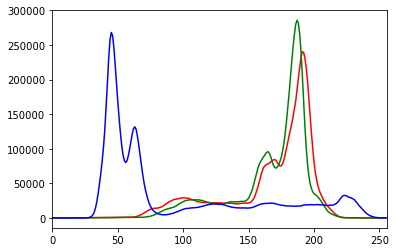

In [6]:
color = ('r','g','b')
img = train_images[0][0]
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

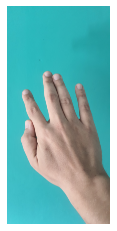

In [7]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [8]:
np.shape(img)

(4032, 1908, 3)

Train shape: (4, 7, 806, 381, 3)
Test shape: (4, 3, 806, 381, 3)


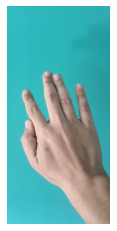

In [9]:
scale_percent = 20
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

train_images_resized = []
for S in train_images:
    s = []
    for im in S:
        s.append(cv2.resize(im, dim, interpolation = cv2.INTER_AREA))
    train_images_resized.append(s)
    
test_images_resized = []
for S in test_images:
    s = []
    for im in S:
        s.append(cv2.resize(im, dim, interpolation = cv2.INTER_AREA))
    test_images_resized.append(s)

import pickle
file = open('dump_train_images_resized', 'wb')
pickle.dump(train_images_resized, file)
file.close()
file = open('dump_test_images_resized', 'wb')
pickle.dump(test_images_resized, file)
file.close()

print("Train shape:", np.shape(train_images_resized))
print("Test shape:", np.shape(test_images_resized))
plt.axis("off")
plt.imshow(cv2.cvtColor(train_images_resized[0][0], cv2.COLOR_BGR2RGB))

In [10]:
train_images_resized = pickle.load(open('dump_train_images_resized', 'rb')
)
test_images_resized = pickle.load(open('dump_test_images_resized', 'rb')
)
winSize = (64,64)
blockSize = (16,16)
blockStride = (16,16) #was (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

def segmentation(image):
    kernel = np.ones((10,10), np.float32)/100
    img = image[:,:,2]

    ret, th1 = cv2.threshold(img,90,255,cv2.THRESH_BINARY)

    th1 = cv2.erode(th1, kernel, iterations = 1)
    th1 = cv2.dilate(th1, kernel, iterations = 1)
    th1 = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, kernel) 
    #MORPH_CLOSE: dilation followed by erosion , useful for closing small holes inside objects

    contours, hier = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    size = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if size < w*h:
            hull = cv2.convexHull(c)

            size = w*h
            hand = image[y:y+h, x:x+w, :]
            hand_bw = th1[y:y+h, x:x+w]
            hand[hand_bw == 0] = 0
            resized_hand = cv2.resize(hand, (128,256), interpolation = cv2.INTER_AREA)
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels) 
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),)    
    hist = hog.compute(resized_hand,winStride,padding,locations)
    
    return hist

training_data = []
training_labels = []
testing_data = []
testing_labels = []

for i in range(4):
    for image in train_images_resized[i]:
        hist = segmentation(image)
        training_data.append(hist)
        training_labels.append(i)
    for image in test_images_resized[i]:
        hist = segmentation(image)
        testing_data.append(hist)
        testing_labels.append(i)
print(len(training_data), len(training_labels), len(testing_data), len(testing_labels))

28 28 12 12


In [11]:
from sklearn import svm

training_data = np.array(training_data).squeeze()
training_labels = np.array(training_labels)
testing_data = np.array(testing_data).squeeze()
testing_labels = np.array(testing_labels)

clf = svm.SVC(decision_function_shape='ovo', kernel = "linear")
clf.fit(training_data, training_labels)
accuracy = clf.score(testing_data, testing_labels)
print("Linear kernel accuracy is ", accuracy)

Linear kernel accuracy is  0.6666666666666666


In [12]:
rbf_max_accuracy = 0
C_max = 0
gamma_max = 0
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
for C in C_range:
    for gamma in gamma_range:
        clf = svm.SVC(decision_function_shape='ovo', kernel = "rbf", C=C, gamma=gamma)
        clf.fit(training_data, training_labels)
        accuracy = clf.score(testing_data, testing_labels)
        if accuracy > rbf_max_accuracy:
            rbf_max_accuracy = accuracy
            C_max = C
            gamma_max = gamma

print("RBF kernel maximum accuracy for C = ", C_max, " and gamma = ", gamma_max, " is ", rbf_max_accuracy)
#https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

RBF kernel maximum accuracy for C =  10.0  and gamma =  0.1  is  0.75


In [13]:
poly_max_accuracy = 0
degree_max = 0
gamma_max_poly = 0
degree_range = np.linspace(1, 10, num = 10).astype(int)
for degree in degree_range:
    for gamma in gamma_range:
        clf = svm.SVC(decision_function_shape='ovo', kernel = "poly", degree=degree, gamma = gamma)
        clf.fit(training_data, training_labels)
        accuracy = clf.score(testing_data, testing_labels)
        if accuracy > poly_max_accuracy:
            poly_max_accuracy = accuracy
            degree_max = degree
            gamma_max_poly = gamma

print("Polynomial kernel maximum accuracy with a degree of ", degree_max, " and gamma ", gamma_max_poly, " is ", poly_max_accuracy)

Polynomial kernel maximum accuracy with a degree of  2  and gamma  0.1  is  0.75


In [14]:
sigmoid_max_accuracy = 0
gamma_max_sigmoid = 0
for gamma in gamma_range:
    clf = svm.SVC(decision_function_shape='ovo', kernel = "sigmoid", gamma = gamma)
    clf.fit(training_data, training_labels)
    accuracy = clf.score(testing_data, testing_labels)
    if accuracy > sigmoid_max_accuracy:
        sigmoid_max_accuracy = accuracy
        gamma_max_sigmoid = gamma
print("Sigmoid kernel maximum accuracy for gamma = ", gamma_max_sigmoid, " is ", sigmoid_max_accuracy)

Sigmoid kernel maximum accuracy for gamma =  1e-09  is  0.4166666666666667
